In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt','r').read().splitlines()
display(words[:3])

['emma', 'olivia', 'ava']

In [4]:
chars = list(set(''.join(words)))
chars.sort()
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3
X, Y = [],[]
for w in words:
    content = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(content)
        Y.append(ix)
        content = content[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
display(X.shape)

torch.Size([228146, 3])

In [7]:
C = torch.randn((27,2))

In [8]:
C[5]

tensor([1.5352, 0.4548])

In [9]:
F.one_hot(torch.tensor(5),num_classes=27).float() @ C 
# @ need the m1 and m2 has the same type nad one_hot need a tensor

tensor([1.5352, 0.4548])

In [10]:
emb = C[X]
display(emb.shape)

torch.Size([228146, 3, 2])

In [11]:
w1 = torch.randn((6,100))
b1 = torch.randn(100)

In [ ]:
torch.flatten(emb,start_dim=1,end_dim=2).shape
torch.cat(torch.unbind(emb, dim=1),1)

tensor([[-1.5095, -0.1689, -1.5095, -0.1689, -1.5095, -0.1689],
        [-1.5095, -0.1689, -1.5095, -0.1689,  1.5352,  0.4548],
        [-1.5095, -0.1689,  1.5352,  0.4548, -0.1751,  1.0012],
        ...,
        [ 1.4002, -1.7509,  1.4002, -1.7509,  1.6597,  0.6345],
        [ 1.4002, -1.7509,  1.6597,  0.6345,  1.4002, -1.7509],
        [ 1.6597,  0.6345,  1.4002, -1.7509, -0.8760,  0.9709]])

In [18]:
h1 = torch.tanh(emb.view(emb.shape[0],6) @ w1 + b1)

In [19]:
h1.shape

torch.Size([228146, 100])

In [20]:
w2 = torch.randn((100,27))
b2 = torch.randn(27)

In [36]:
logits = h1 @ w2 + b2
counts = (logits-logits.max()).exp() 
display(counts.shape)
display(logits.max())

torch.Size([228146, 27])

tensor(37.3723)

In [37]:
prods = counts / counts.sum(dim=1,keepdim=True)

In [38]:
loss = -prods[prods.shape[1],Y].log().mean()
loss

tensor(13.0584)

In [142]:
len(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr = X[0:n1]
Xdev = X[n1:n2]
Xte =X[n2:]
Ytr = Y[0:n1]
Ydev = Y[n1:n2]
Yte = Y[n2:]

# Train part

In [184]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
w1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300,generator=g)
w2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,w1,w2,b1,b2]

In [185]:
for p in parameters:
    p.requires_grad = True

In [186]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [187]:
lri = []
lossi = []
for  i in range(10000):
    ix = torch.randint(0,Xdev.shape[0],(32,))
    emb = C[Xdev[ix]]
    h = torch.tanh(emb.view(-1,6) @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,Ydev[ix])
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1
    if i >5000:
        lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad
    lri.append(i)
    lossi.append(loss.item())
print(loss)

tensor(2.2136, grad_fn=<NllLossBackward0>)


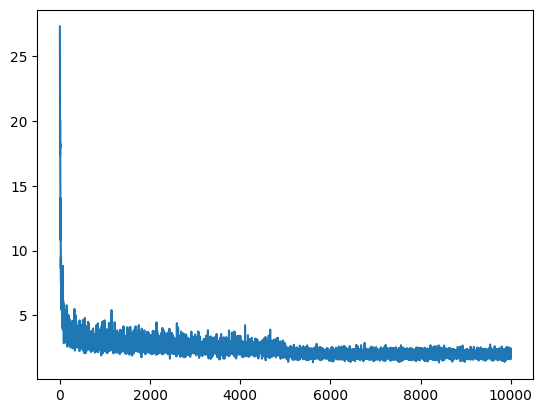

In [188]:
plt.plot(lri,lossi)

# Dev loss

In [189]:
emb = C[Xte]
h = torch.tanh(emb.view(-1,6)@ w1+ b1)
logits = h @ w2 + b2
loss = F.cross_entropy(logits, Yte)
print(f"dev loss: {loss}") 

dev loss: 2.8563382625579834


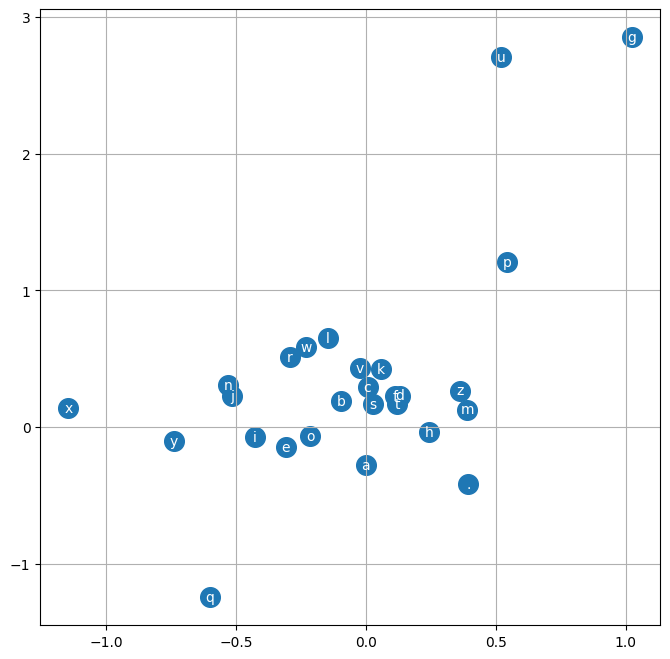

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], va='center', ha='center', color='white')
plt.grid('minor')

# predict

In [195]:
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

junidma.
anasizha.
cear.
adin.
kailelto.
cami.
gez.
kalinah.
yamilenias.
dedaile.
